In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scienceplots
import pandas as pd
from tensorflow import keras
from utils.helper import (
    folder_to_sequence,
    MinMaxScaler_AE,
)

import sys
sys.path.append("../")
from train_model import PARAMETERS

plt.style.use(["science", "ieee", "notebook"])

plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.figsize"] = (9, 4)

In [10]:
# carregando os dados para a memória
DEFAULT_WS = PARAMETERS["window_size"]
normal = folder_to_sequence("VIDRO-B3", DEFAULT_WS)

anomalies = [
    folder_to_sequence("ANOMALIAS/B3+200g", DEFAULT_WS),
    folder_to_sequence("ANOMALIAS/B3-200g", DEFAULT_WS),
    folder_to_sequence("PAINCO", DEFAULT_WS),
    folder_to_sequence("VIDRO-B2", DEFAULT_WS),
]

transient = folder_to_sequence("ANOMALIAS/Transiente", DEFAULT_WS)

100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


In [11]:
scaler = MinMaxScaler_AE()
scaler.fit(normal)
autoencoder = keras.models.load_model("../models/best_model.keras")

In [29]:
# 1) Analisar os erros no conjunto de treino


def get_error_dist(data: np.ndarray) -> np.ndarray:
    xnorm = scaler.transform(data)
    xpred = autoencoder.predict(xnorm)

    xnorm = np.squeeze(xnorm, axis=-1)
    errors = np.mean(np.abs(xnorm - xpred), axis=1)

    return errors


def plot_error_dist(
    error_dist: np.ndarray,
    threshold: float,
    color: str,
    cumulative=False,
):
    fig, ax = plt.subplots()
    ax.grid()
    sns.histplot(
        error_dist,
        kde=True,
        bins=50,
        color=color,
        stat="percent",
        ax=ax,
        cumulative=cumulative,
    )
    ax.set_ylabel(r"Porcentagem (%)")
    ax.set_xlabel("Erro médio absoluto")
    ax.axvline(threshold, color="black", linestyle="--", label="Limiar")
    ax.legend()
    ax.legend(title=f"Acurácia: {get_accuracy(error_dist, threshold) * 100:.2f}%")
    return ax
    
def plot_anomalies(
    data: np.ndarray,
    errors: np.ndarray,
    max_error: float,
    window_size: int = DEFAULT_WS,
    ):
    anomaly_points = errors > max_error
    combined_anomaly_points = np.zeros_like(anomaly_points, dtype=bool)
    for i in range(window_size - 1, len(anomaly_points)):
        if np.all(anomaly_points[i - window_size + 1 : i + 1]):
            combined_anomaly_points[i] = True

    fig, ax = plt.subplots()
    ax.plot(data[:, 0, 0])
    ax.scatter(
        np.where(combined_anomaly_points)[0], data[combined_anomaly_points, 0, 0], c="r"
    )
    ax.set_xlabel("Frame")
    ax.set_ylabel("Pressão Normalizada")
    return fig, ax




In [13]:
def get_accuracy(errors: np.ndarray, threshold: float) -> float:
    anomalies = errors > threshold
    accuracy: float = np.mean(anomalies)
    return accuracy

In [14]:
normal_err = get_error_dist(normal)
threshold = np.percentile(normal_err, 95)

998/998 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step


<Axes: xlabel='Erro médio absoluto', ylabel='Porcentagem (%)'>

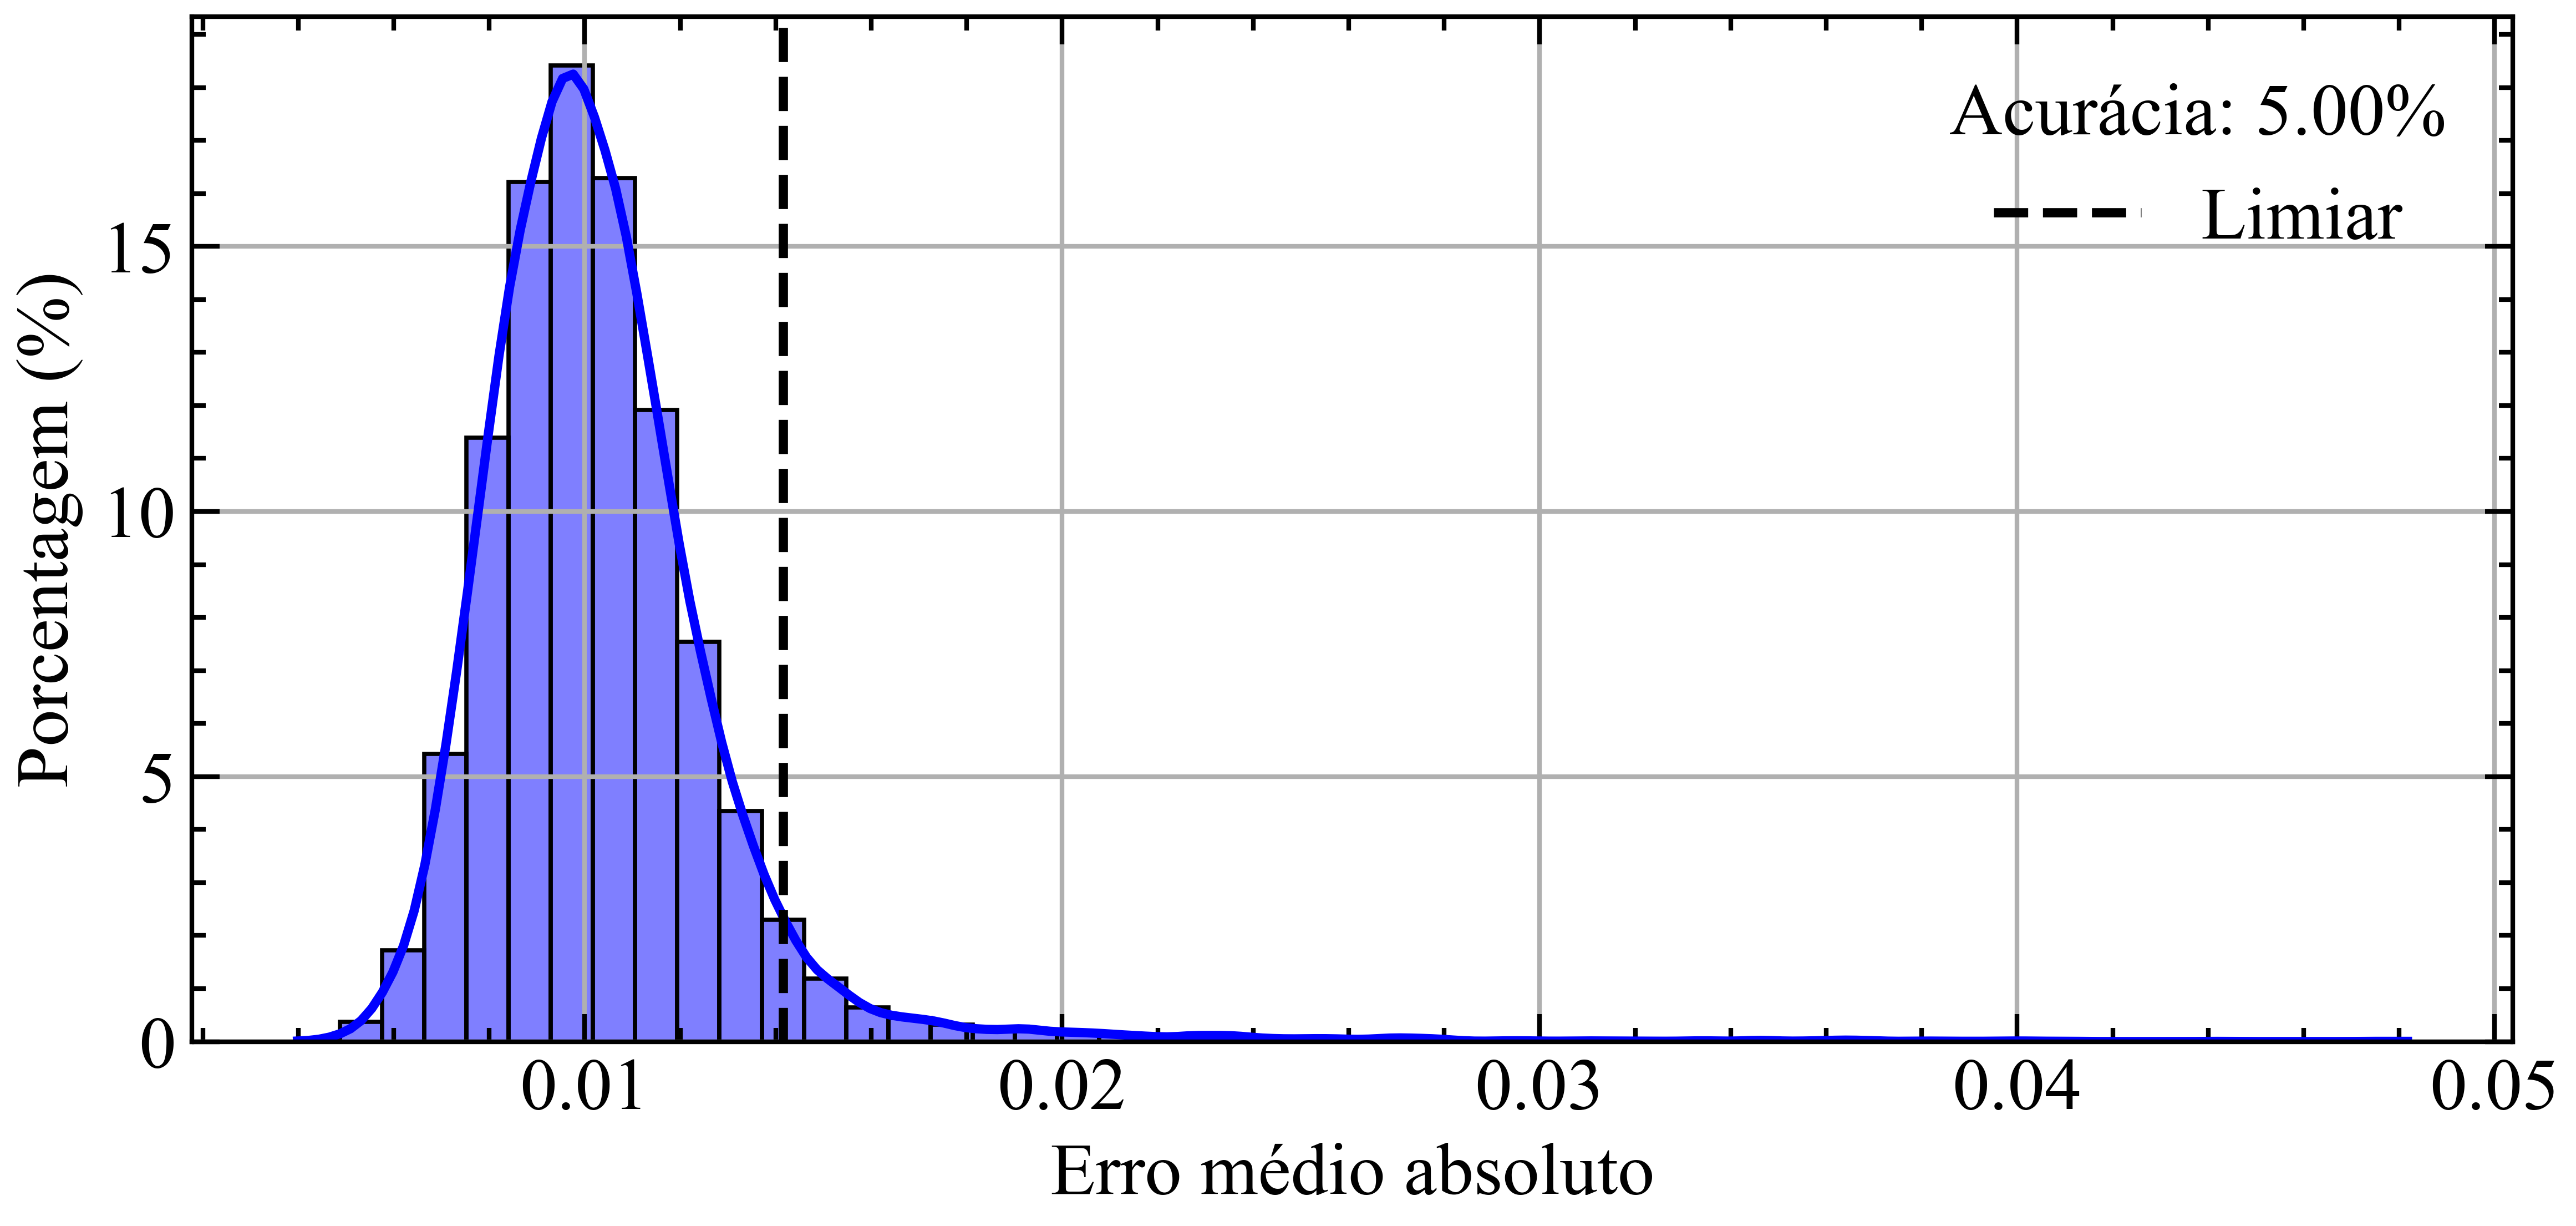

In [9]:
plot_error_dist(normal_err, threshold, "blue")

In [15]:
errors = [get_error_dist(anomaly) for anomaly in anomalies]

265/265 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


<Axes: xlabel='Erro médio absoluto', ylabel='Porcentagem (%)'>

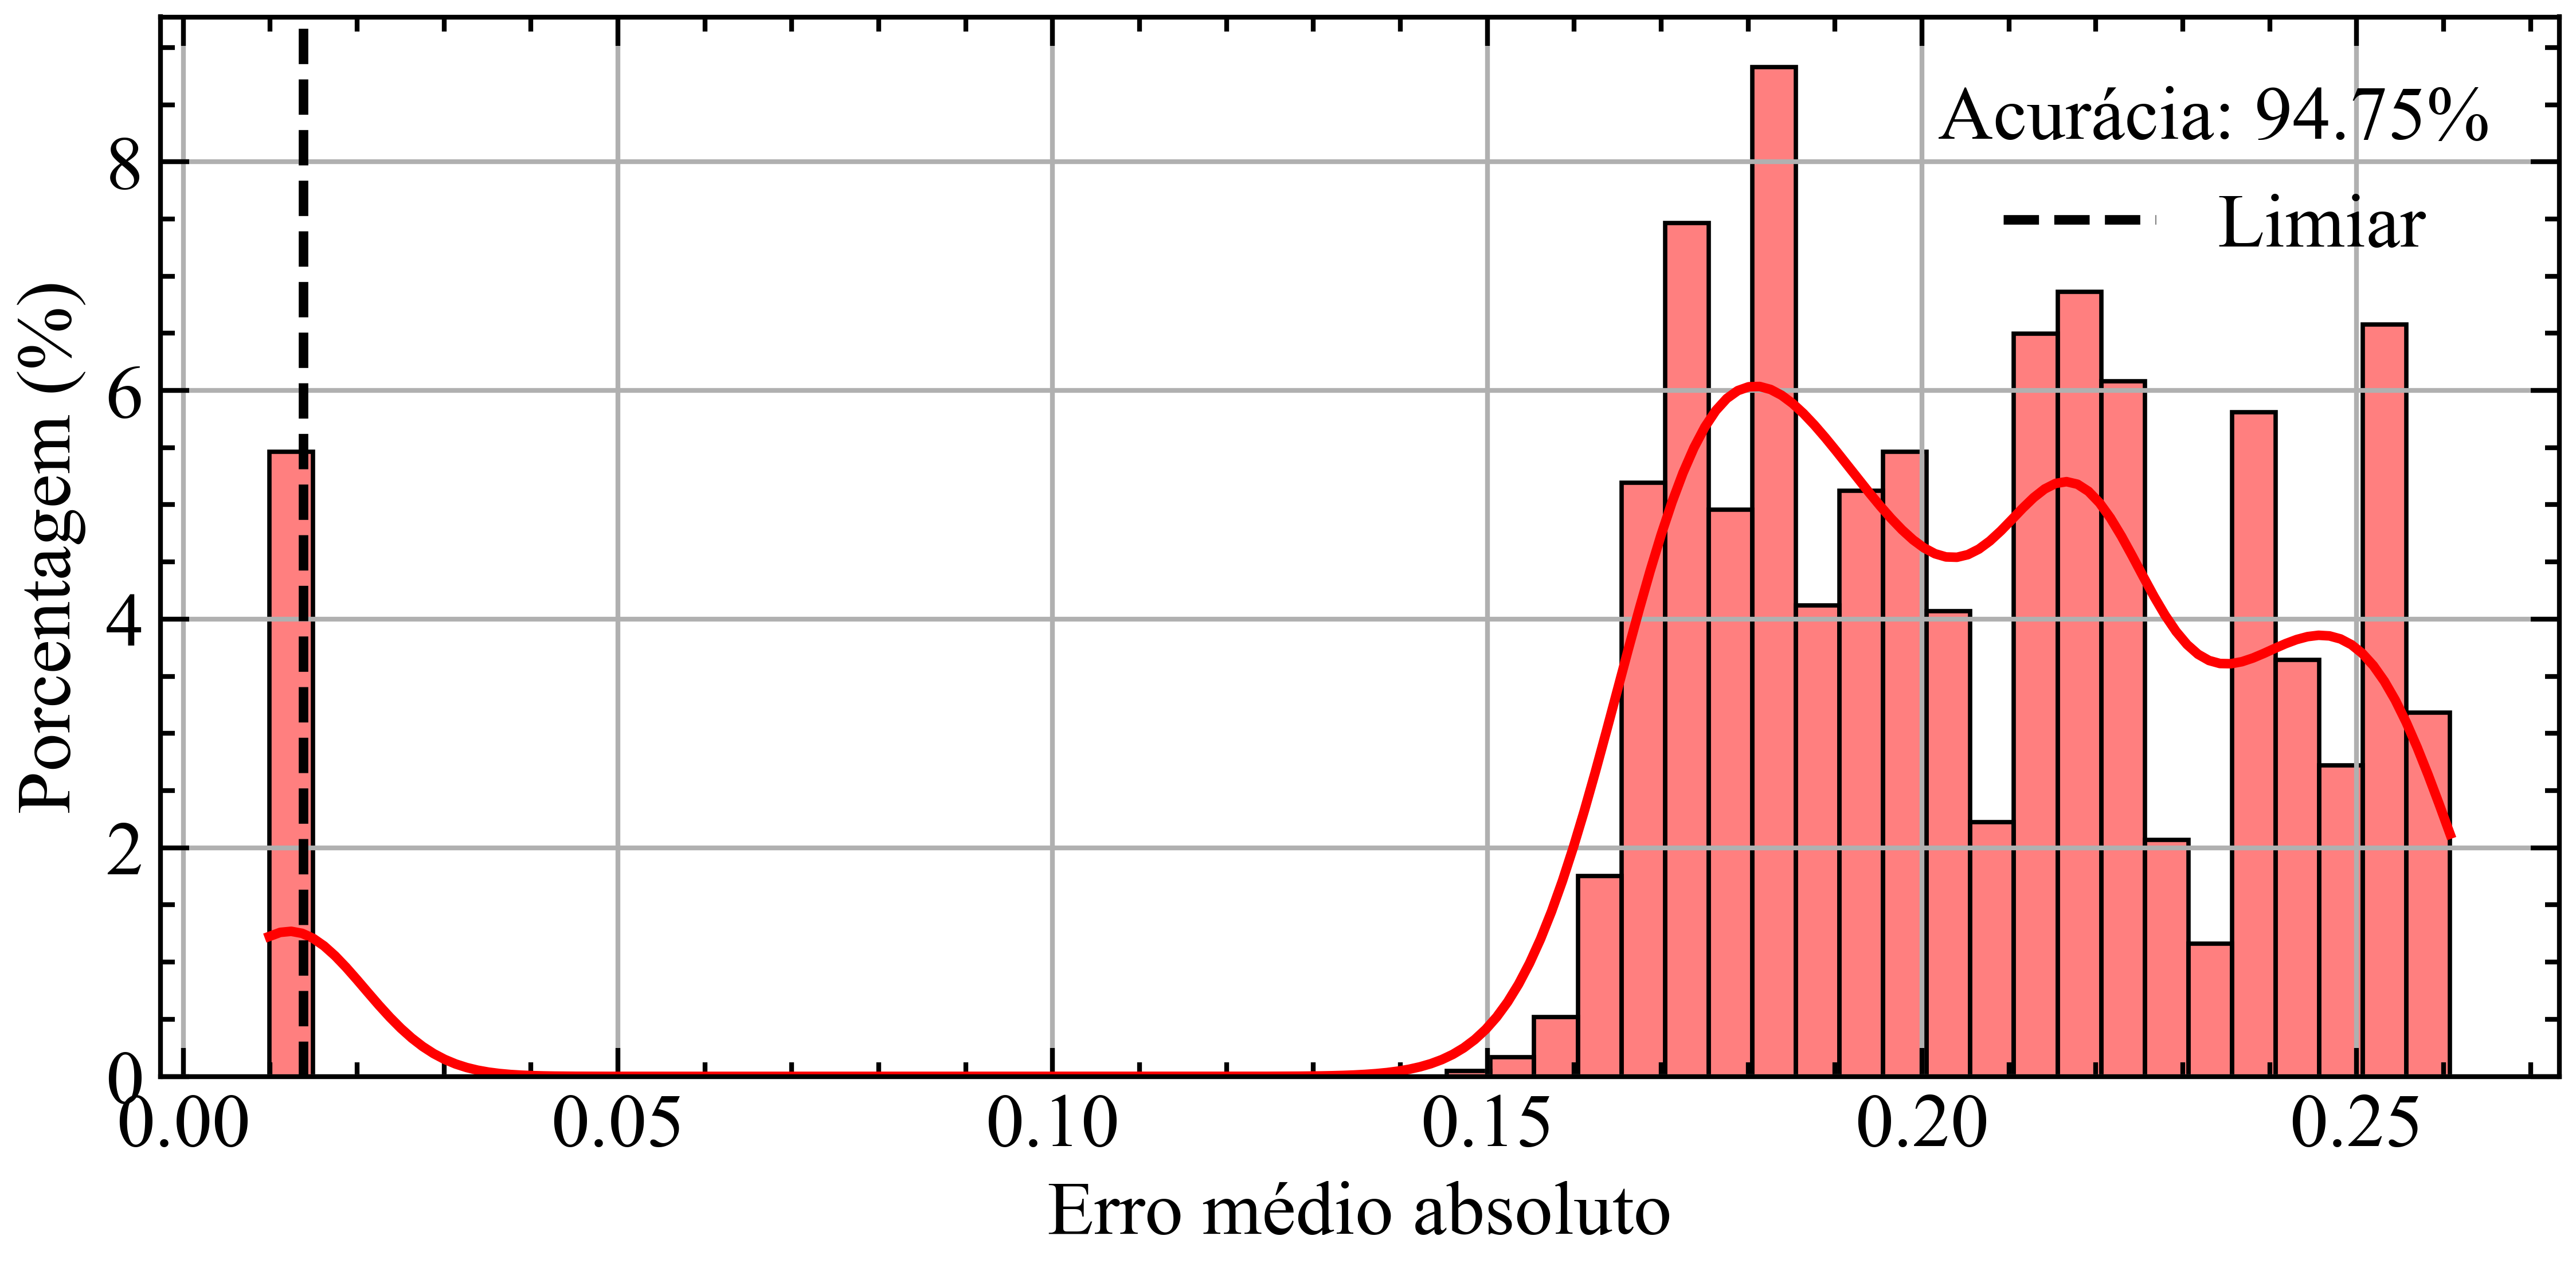

In [16]:
plot_error_dist(errors[0], threshold, "red")

<Axes: xlabel='Erro médio absoluto', ylabel='Porcentagem (%)'>

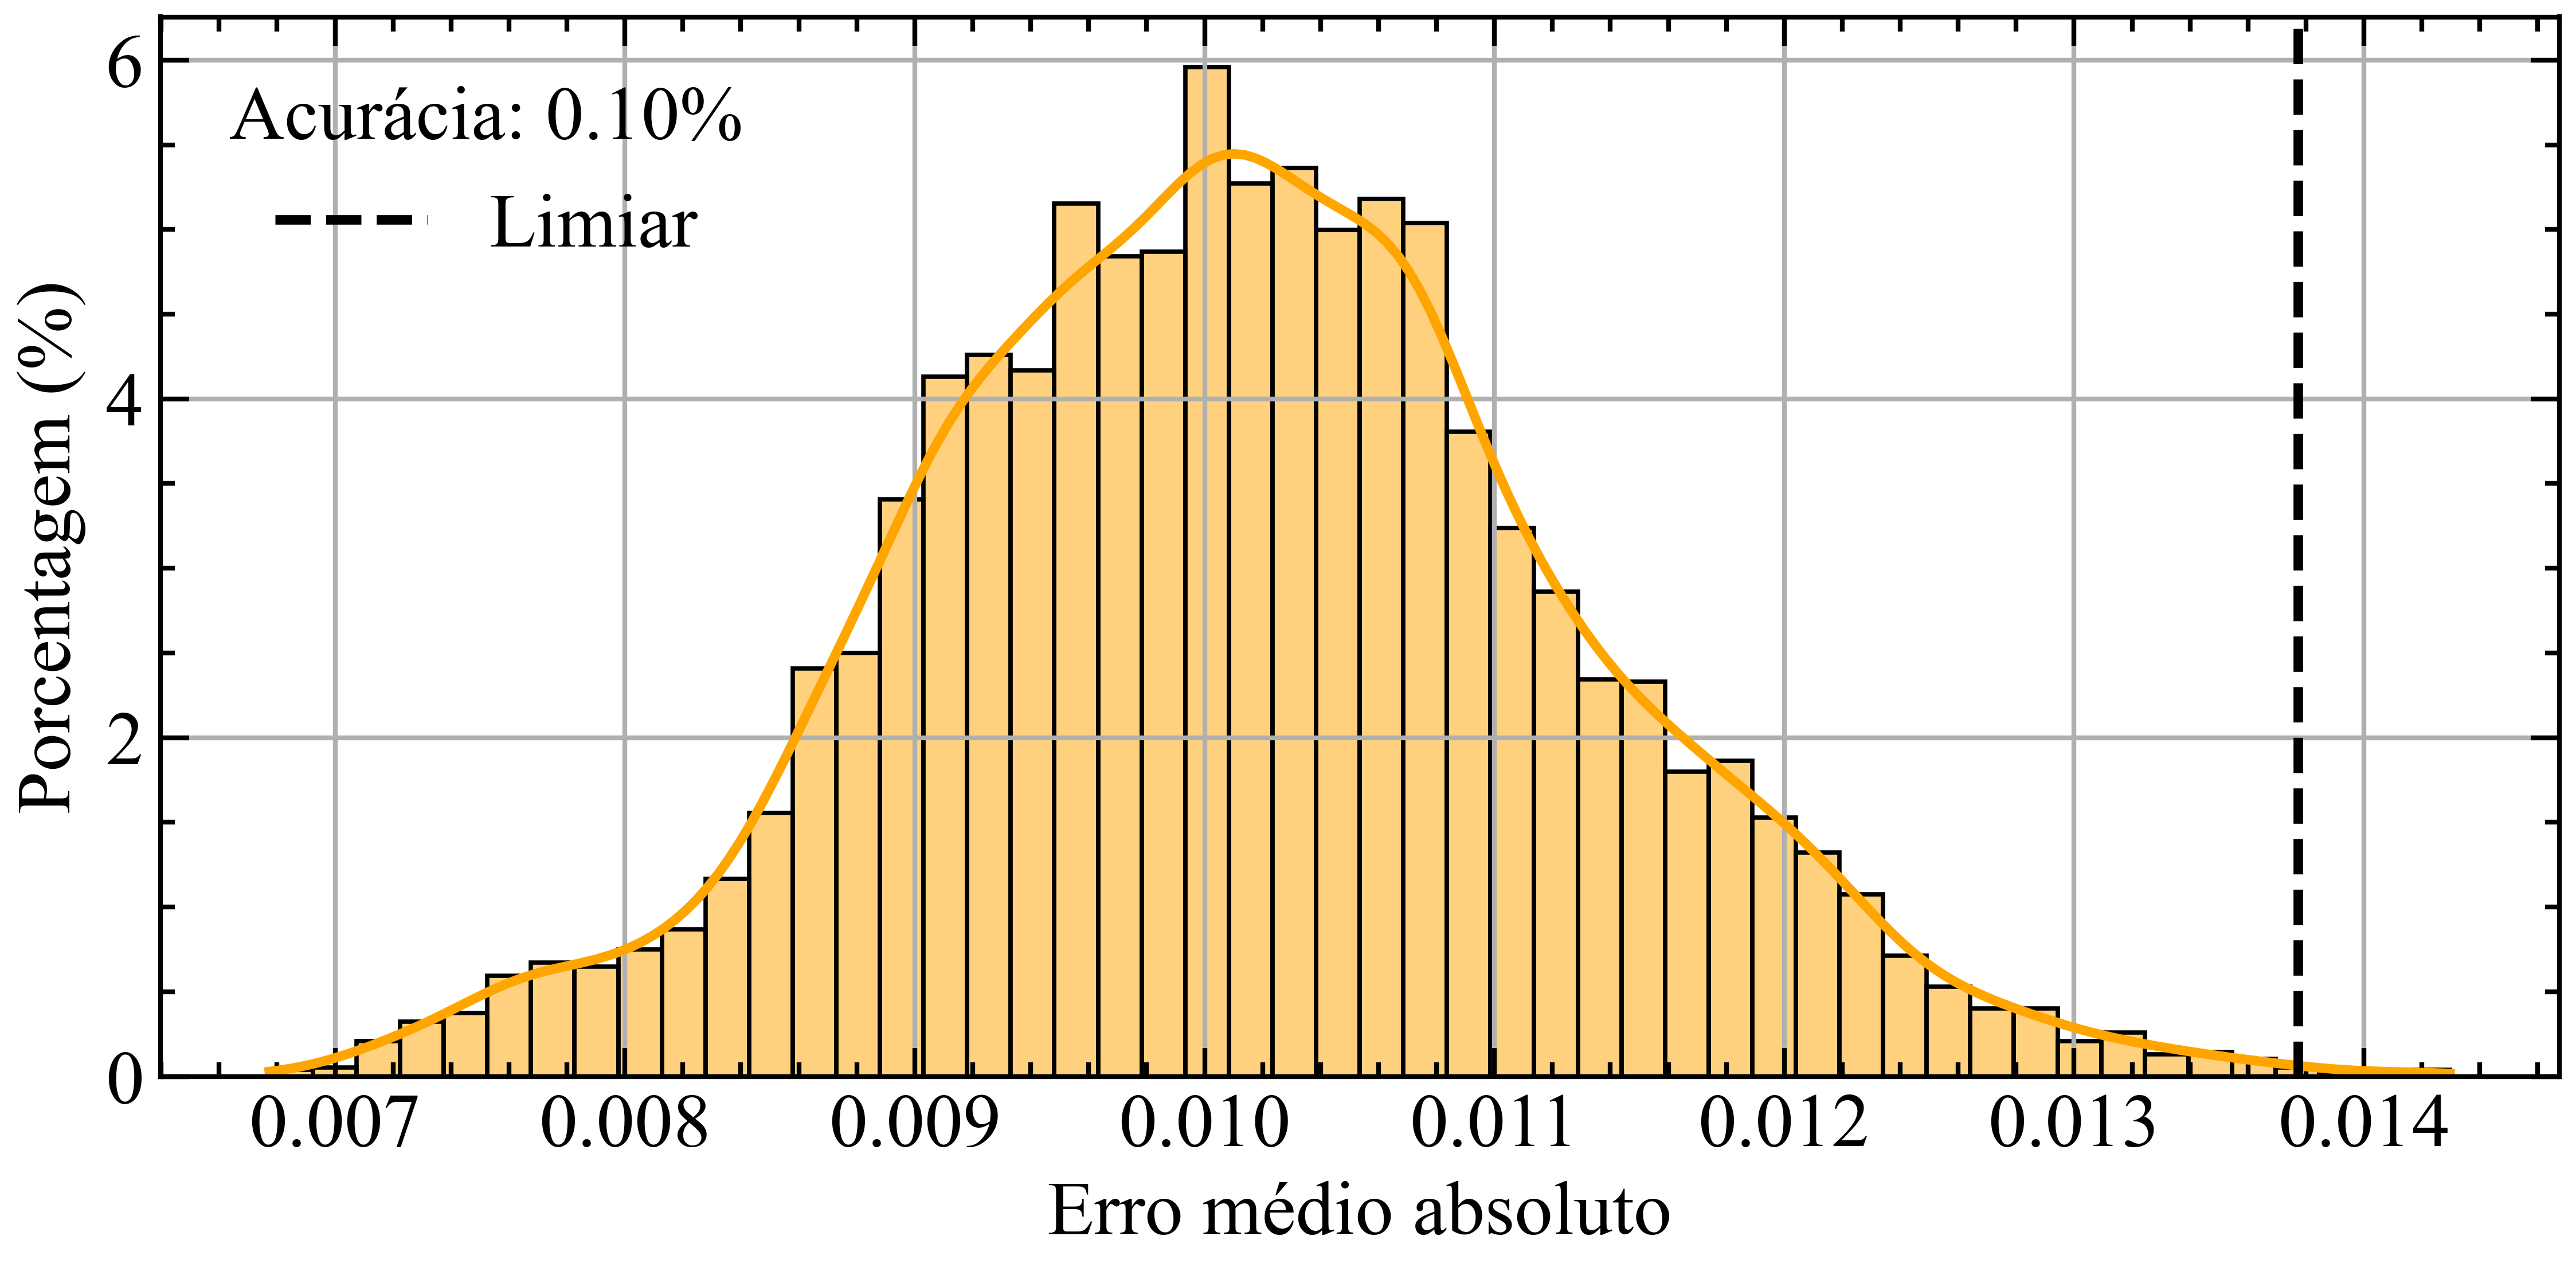

In [17]:
plot_error_dist(errors[1], threshold, "orange")

<Axes: xlabel='Erro médio absoluto', ylabel='Porcentagem (%)'>

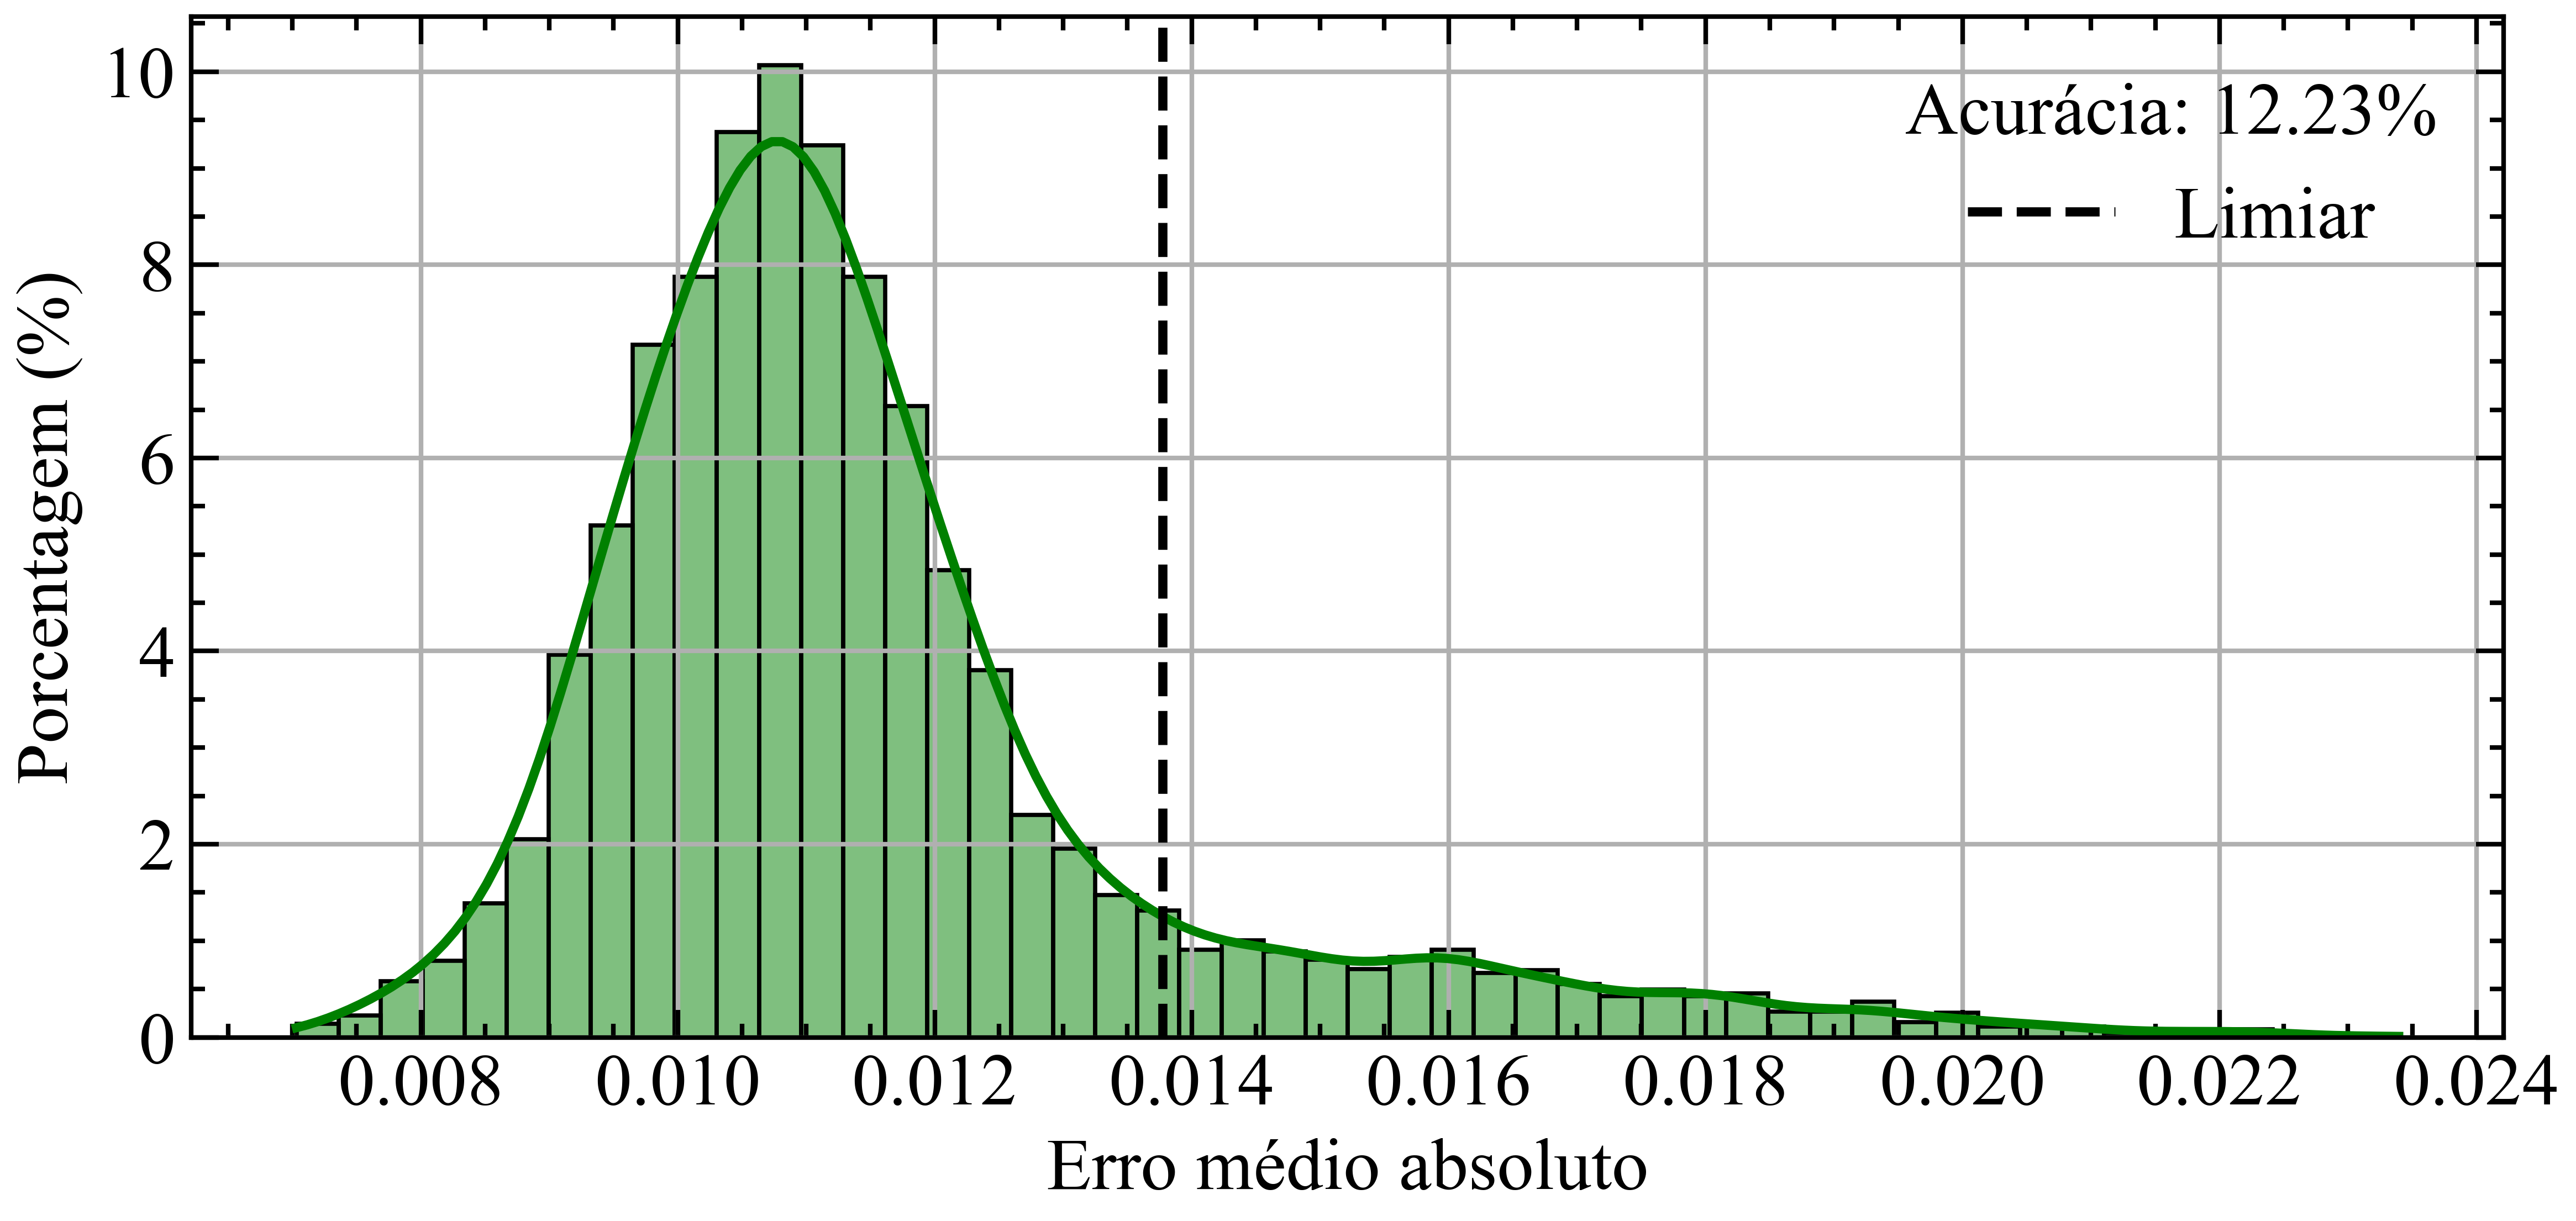

In [23]:
plot_error_dist(errors[3], threshold, "green")

(<Figure size 5400x2400 with 1 Axes>,
 <Axes: xlabel='Frame', ylabel='Pressão Normalizada'>)

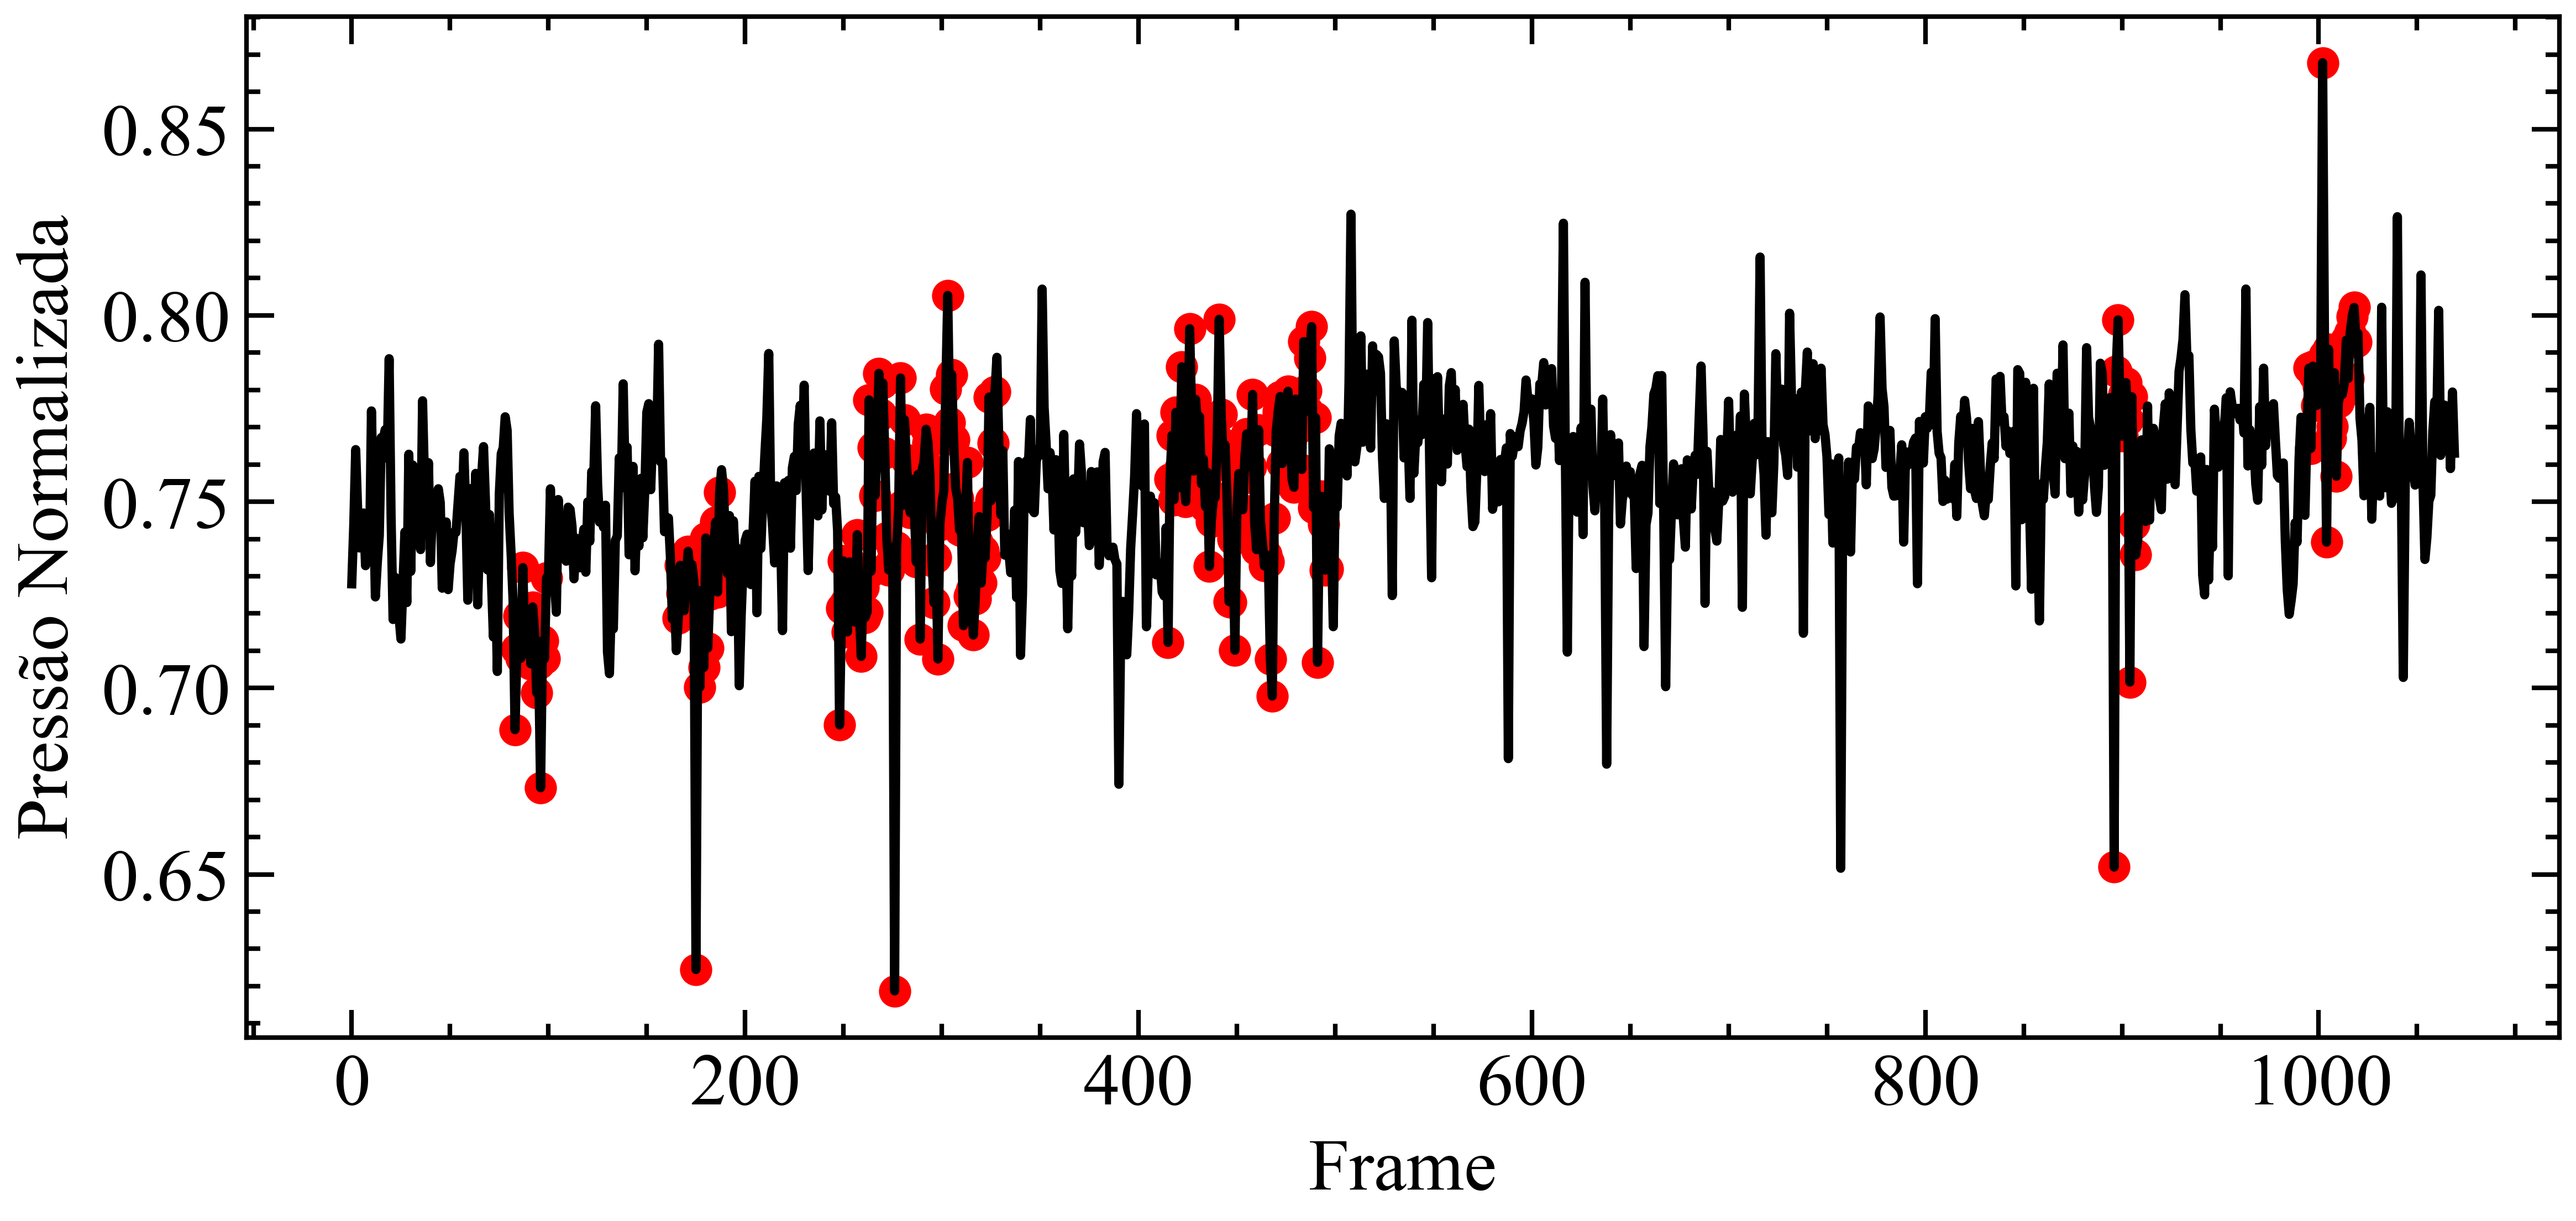

In [28]:
plot_anomalies(anomalies[3][6000:], errors[3][6000:], threshold)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


(<Figure size 5400x2400 with 1 Axes>,
 <Axes: xlabel='Frame', ylabel='Pressão Normalizada'>)

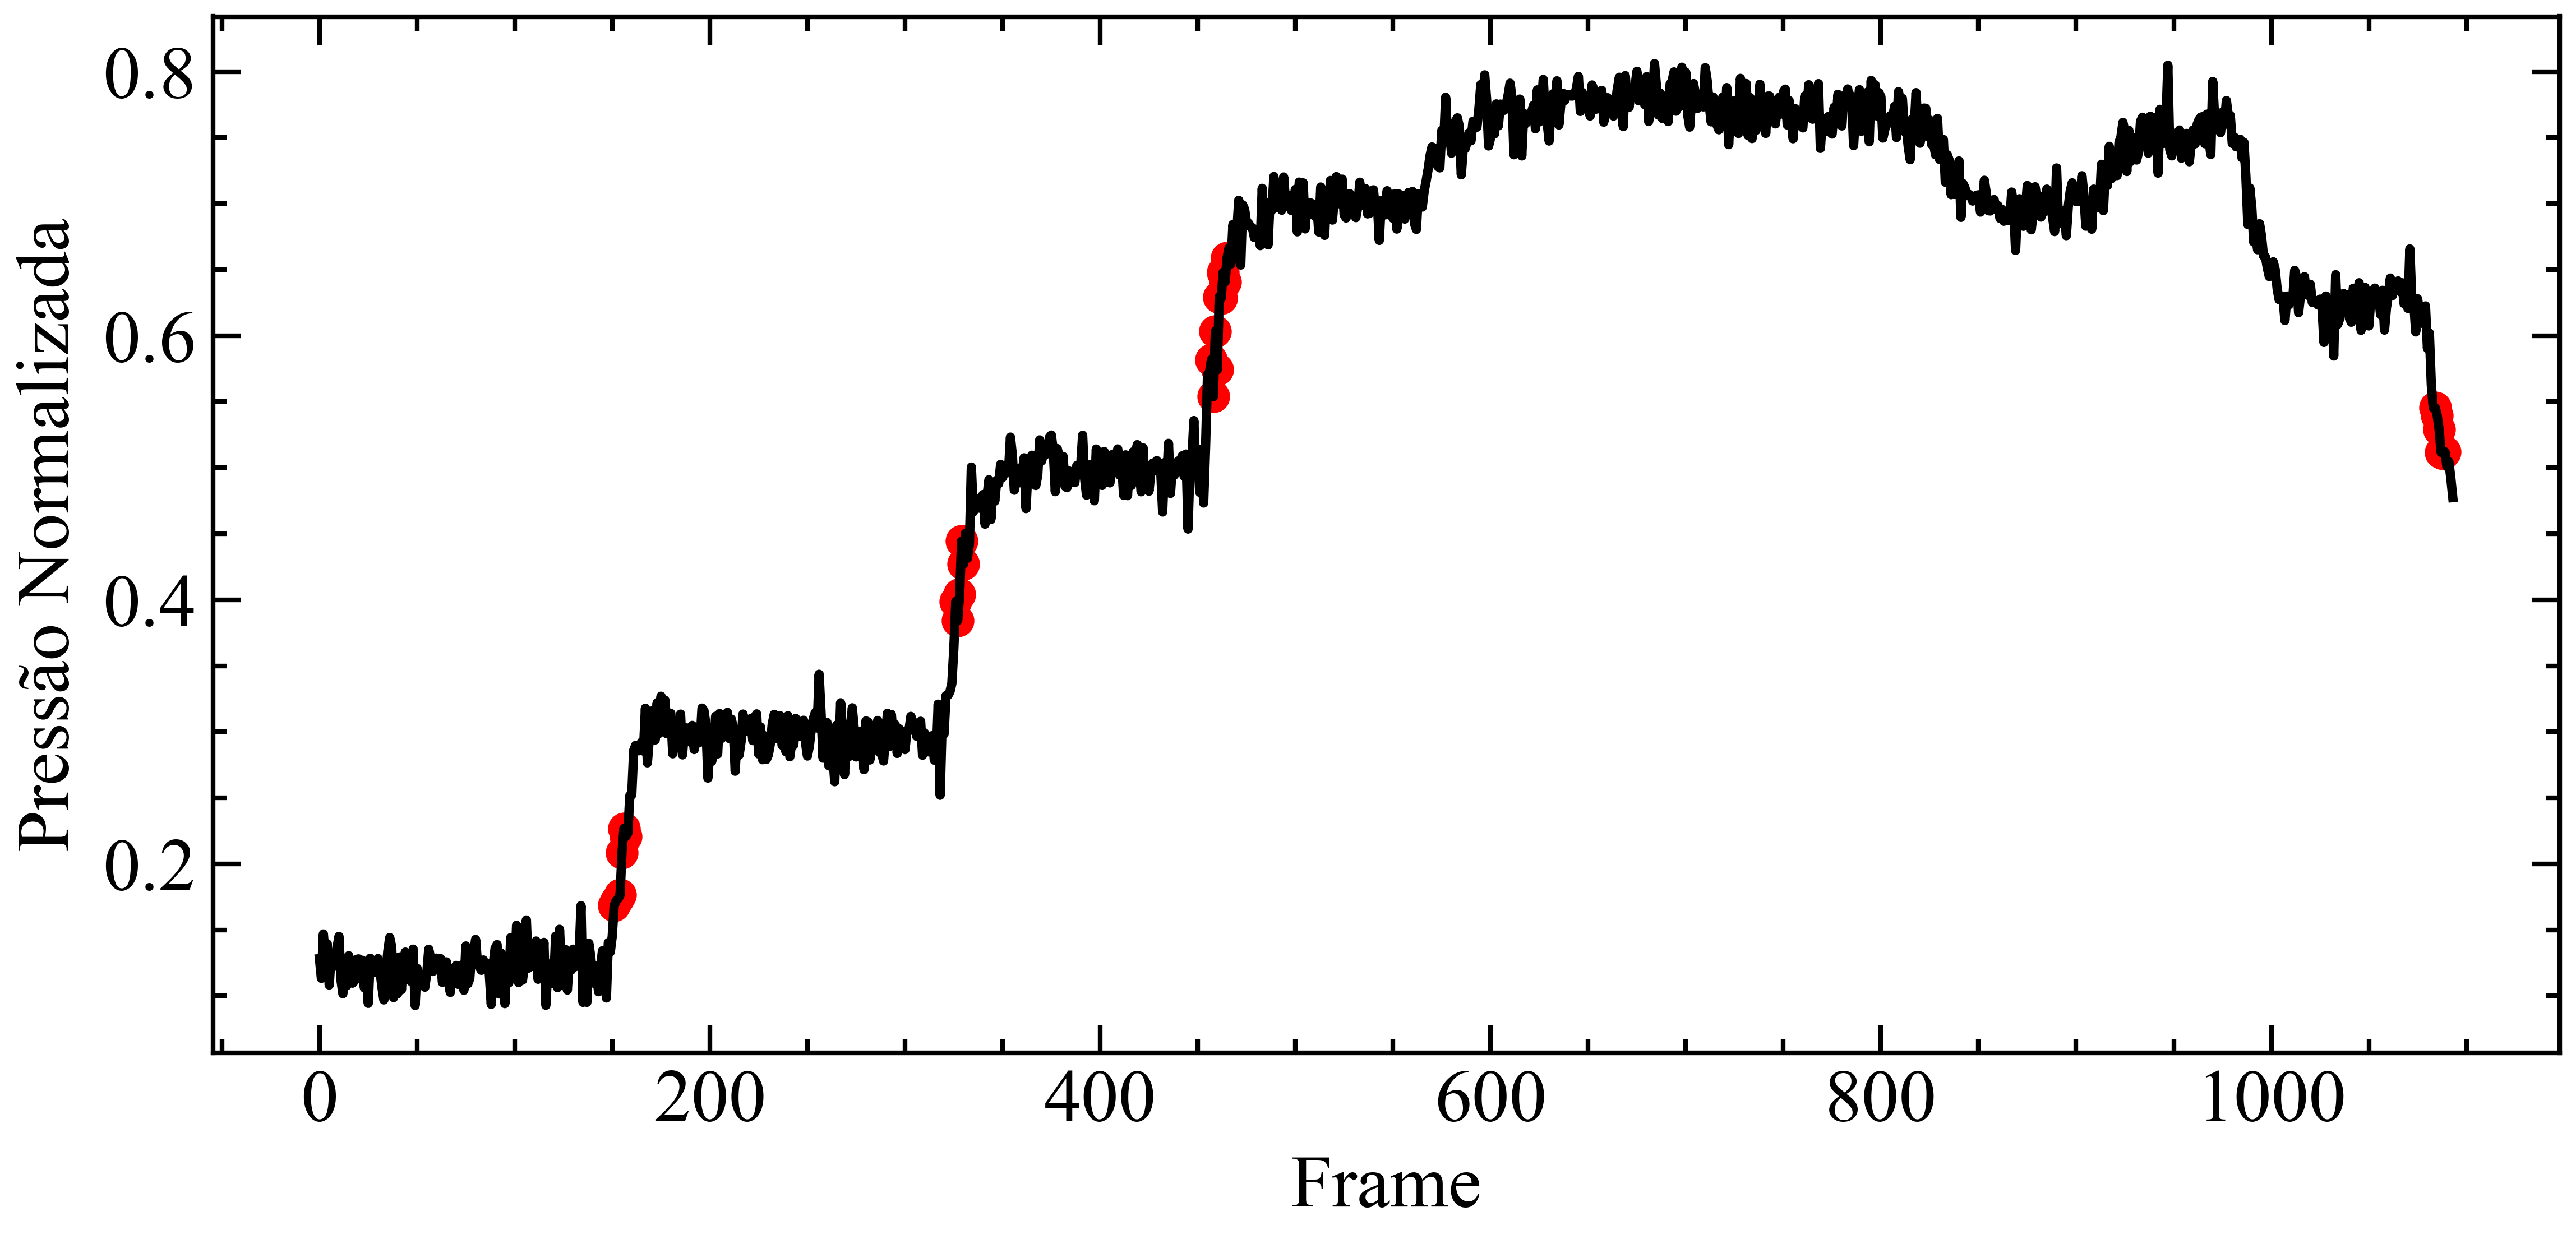

In [27]:
# Exemplo de uso da função
# index: int = 4
# plot_anomalies(anomalies[index], errors[index], threshold)
plot_anomalies(transient, get_error_dist(transient), threshold)

265/265 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step


(<Figure size 5400x2400 with 1 Axes>,
 <Axes: title={'center': 'Anomaly Detection'}, xlabel='Time', ylabel='Value'>)

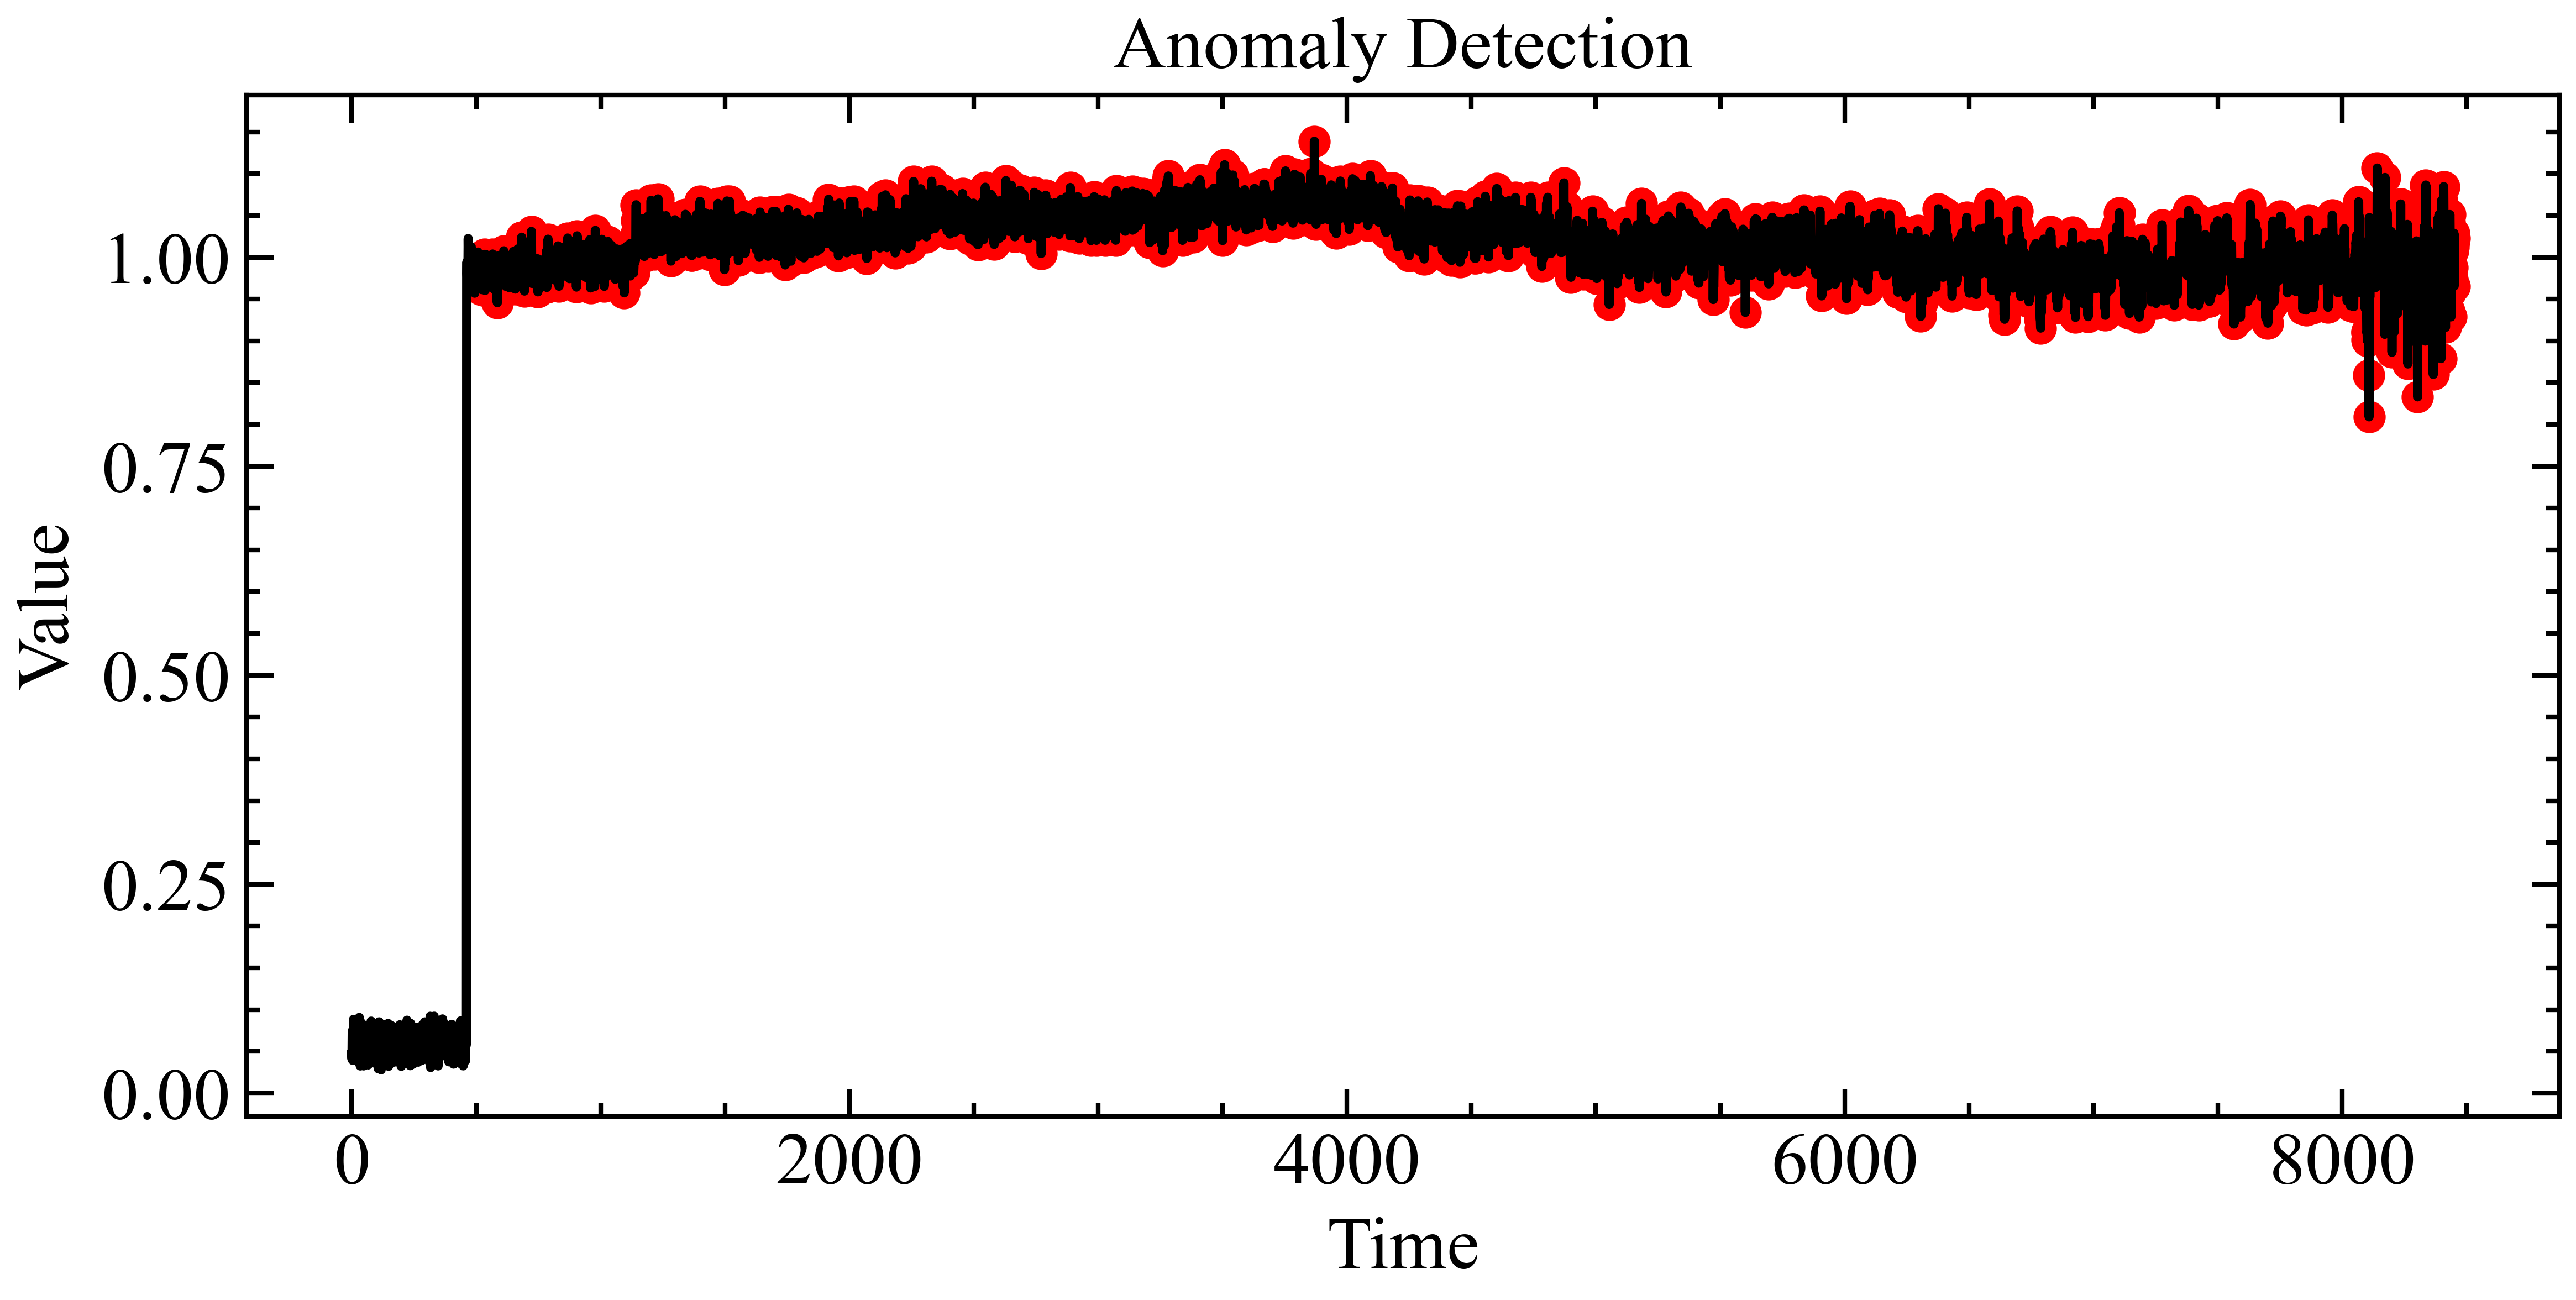

In [20]:
plot_anomalies(anomalies[0], get_error_dist(anomalies[0]), threshold)

In [21]:
def calculate_thresholds_and_accuracies(
    normal_data, anomaly_data_list, percentiles=[90, 95, 100]
) -> pd.DataFrame:
    # Normalize the normal data
    xnorm = scaler.transform(normal_data)
    xpred = autoencoder.predict(xnorm)
    xnorm = np.squeeze(xnorm, axis=-1)
    errors = np.mean(np.abs(xnorm - xpred), axis=1)

    # Calculate thresholds based on percentiles
    thresholds = {p: np.percentile(errors, p) for p in percentiles}

    # Calculate accuracies for each anomaly dataset
    accuracies = {p: [] for p in percentiles}
    for anomaly_data in anomaly_data_list:
        xnorm_anomaly = scaler.transform(anomaly_data)
        xpred_anomaly = autoencoder.predict(xnorm_anomaly)
        xnorm_anomaly = np.squeeze(xnorm_anomaly, axis=-1)
        errors_anomaly = np.mean(np.abs(xnorm_anomaly - xpred_anomaly), axis=1)

        for p in percentiles:
            threshold = thresholds[p]
            accuracy = get_accuracy(errors_anomaly, threshold)
            accuracies[p].append(accuracy)

    # Create a DataFrame to store the results
    results = pd.DataFrame(
        {
            "Percentil": percentiles,
            "Limiar": [thresholds[p] for p in percentiles],
        }
    )

    for i, anomaly_data in enumerate(anomaly_data_list):
        results[f"Anomaly {i+1} Acc (%)"] = [
            accuracies[p][i] * 100 for p in percentiles
        ]

    return results


# Calcular a tabela de limiares e acurácias
results_table = calculate_thresholds_and_accuracies(normal, anomalies)
results_table.set_index("Percentil", inplace=True)
print(results_table)

998/998 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step
265/265 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step
             Limiar  Anomaly 1 Acc (%)  Anomaly 2 Acc (%)  Anomaly 3 Acc (%)  \
Percentil                                                                      
90         0.012534          96.888310           2.149702          78.584365   
95         0.013773          94.746805           0.103600          77.829762   
100        0.025838          94.533838           0.000000          77.361908   

           Anomaly 4 Acc (%)  
Percentil                     
90                 19.335219  
95                 12.234795  
100                 0.000000  


In [22]:
caption = "Acurácia de detecção de anomalias para diferentes limiares."
position = "H"
label = "tab:acuracias"
header = [
    "Limiar",
    "+200g",
    "-200g",
    "Painço",
    "Vidro B2",
]

print(
    results_table.to_latex(
        float_format="%.2f",
        decimal=",",
        caption=caption,
        position=position,
        label=label,
        column_format="c"*(len(anomalies) + 1),
        header=header,
    )
)

\begin{table}[H]
\caption{Acurácia de detecção de anomalias para diferentes limiares.}
\label{tab:acuracias}
\begin{tabular}{ccccc}
\toprule
 & Limiar & +200g & -200g & Painço & Vidro B2 \\
Percentil &  &  &  &  &  \\
\midrule
90 & 0,01 & 96,89 & 2,15 & 78,58 & 19,34 \\
95 & 0,01 & 94,75 & 0,10 & 77,83 & 12,23 \\
100 & 0,03 & 94,53 & 0,00 & 77,36 & 0,00 \\
\bottomrule
\end{tabular}
\end{table}

